In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

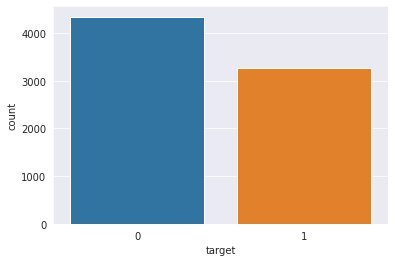

In [ ]:
sns.countplot(train['target'])

In [ ]:
train.drop(['id','location','keyword'], axis = 1,inplace=True)
test.drop(['id','location','keyword'], axis = 1,inplace=True)

## BERT model

In [ ]:
%%capture
!pip install bert-for-tf2
!pip install transformers

In [ ]:
#importing libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization
from transformers import BertModel, BertTokenizer
import re
import string

In [ ]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
#encoding text for BERT
def bert_encode(texts, tokenizer, max_len=512):
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in texts:
    text = tokenizer.tokenize(text)

    text = text[:max_len-2]
    input_sequence = ['[CLS]'] + text + ['[SEP]']
    pad_len = max_len - len(input_sequence)

    tokens = tokenizer.convert_tokens_to_ids(input_sequence)
    tokens += [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * max_len

    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
#building model
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#data cleaning
def lowercase_text(text):
    return text.lower()

train.text=train.text.apply(lambda x: lowercase_text(x))
test.text=test.text.apply(lambda x: lowercase_text(x))

def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train.text=train.text.apply(lambda x: remove_noise(x))
test.text=test.text.apply(lambda x: remove_noise(x))

In [ ]:
#Pre-Training BERT
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1: 1.03GB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1, Total size: 1.26GB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [ ]:
#Modelling
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=1,#shd be 2
    callbacks=[checkpoint],
    batch_size=16
)

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission['target'] = test_pred.round().astype(int)
submmission.to_csv('my_submission.csv',index=False)